In [1]:
import numpy as np
import random
import copy
import globals as gb
from tqdm.auto import tqdm
from dataclasses import dataclass
from tree import Tree, swap_subtrees, generate_initial_solution
from utils import mse, sort_individuals
from mutations import mutation
from tree_node import TreeNode

## Problem selection

In [180]:
# Select which problem to get input variables from by inserting the desired problem id as argument of the following function
gb.initialize_globals_for_problem(2)

POPULATION_SIZE = gb.PROBLEM_SIZE * 20
OFFSPRING_SIZE = int(POPULATION_SIZE / 4)
MAX_ITERATIONS = 10000 - gb.PROBLEM_SIZE * 2000 if gb.PROBLEM_SIZE < 5 else 1000

In [ ]:
test = generate_initial_solution()
test.draw_tree()

## Steps
- We treat a possible solution as a tree. The tree has attribute root, which is the root of the tree of class TreeNode and max_depth.
- Generate random tree
    - we need each variable at least once 
    - each variable has exactly one coefficient chosen as a random float number in the range [?, ?]
    - each variable has exactly one unary operator
    - unary operator is chosen as: 50% chance of "" (i.e. no change to the variable), 50% chance of choosing among all other unary operators
        - check if the unary operator is appliable to the variable ->
            ```
            leaves_map = {}
            for e in leaves:
                available_unary_operators = [op for op in list(UNARY_OPERATORS.keys()) if op.is_applicable(e)]
                chosen_unary_operator = 50% chance of "" (i.e. no change to the variable), 50% chance of choosing among [available_unary_operators]
                leaves_map[e] = [chosen_unary_operator]
            # leaves = [-2, 3]
            # leaves_map = {-2: square, 3: log}
            for e in leaves:
                node = leaves_map[e]
                node.left = null
                node.right = e
                # insert node to tree
            ```
    - number of leaves = nearest power of two greater than keys.length()
    - number of actual leaves = [number of leaves] * 2
    - number of coefficients = [number of leaves] - keys.length()
    - number of binrary operators = total number of nodes in  tree with [number of leaves] leaves - [number of leaves]]
    - validate tree
    - if valid, return tree
    - else, ?
- Example:
    - x.length() = 3
    - number of leaves = 4
    - number of actual leaves = 8
    - number of coefficients = 1
    - number of operands = 3

    ```bash
                    +
            /                  \
            *                    +
        /      \           /        \
      u        1          1          u
    /   \    /   \      /   \       /  \
    nul  *  nul   *    nul    *     nul *
    ```
### EA approach
- Individual is rapresented as a tree and a fitness
    - fitness is a tuple of 2 values: (-mse, right_sign_100)
        - right_sign_100 is the percentage of correct sign predictions
        - mse is the mean squared error
- Classic Genetic Programming
    - Key elements 
    - Representation: tree structures
    - Recombination: exchange of subtrees
    - Mutation: random change in trees
        - subtree mutation -> replace  entire subtree
        - point  mutation -> change single node
        - permutation -> exchange node right with left
        - hoist -> take subtree and make it root
        - expansion -> take random leaf and replace it with a new subtree
        - collapse -> take a subtree and replace it with leaf
    - Population model: generational
    - Parent selection: fitness proportional
    - Survivor selection: deterministic

##next

    - finish implementing mutations
    - find way to reduce tree dimension
    - add weights to opertors
    - add check if fitness doesn't improve , stop early
    - 

##problems
    - overflow
    - initial tree with 4xnodes has invalid values
    - 


## Individual definition

In [181]:
@dataclass
class Individual:
    genome: Tree
    fitness: tuple

## Fitness evaluation

In [182]:
def fitness(sol: Tree):
    y_computed = sol.root.evaluate_tree_from_node()
    right_sign_100 = 100 * np.sum(np.sign(y_computed) == np.sign(gb.Y)) / len(gb.Y)
    n_expected_leaves = int(2 ** np.ceil(np.log2(gb.PROBLEM_SIZE)))
    expected_depth = np.log2(n_expected_leaves * 2) + 1
    depth_penalty = (np.exp((sol.get_max_depth() / expected_depth)) - 1) if sol.get_max_depth() > expected_depth else 0
    
    leaves = [node.value for node in sol.get_leaves_nodes()]
    missing_variables = [x for x in list(gb.VARIABLES_MAP.keys()) if x not in leaves]
    missing_variables_penalty = (np.exp((len(missing_variables) / len(list(gb.VARIABLES_MAP.keys())))) - 1) if len(missing_variables) > len(list(gb.VARIABLES_MAP.keys())) else 0

    return  -mse(y_computed, gb.Y) * (1 + depth_penalty + missing_variables_penalty), right_sign_100

## EA helper functions

In [183]:
def parent_selection(population: list[Individual], scores, worst_score):
    # windowing    
    scores_prime = [(s-worst_score) for s in scores]
    total = sum(scores_prime)
    # if all population doesn't have some score
    if total != 0:
        probabilities = [s/total for s in scores_prime]

        parents = random.choices(population, probabilities, k=2)
            
        return parents[0], parents[1]
    
    return population[0], population[1]

def xover(parent1, parent2)-> tuple[Tree, tuple]:
    # reproduce
    c1 = copy.deepcopy(parent1.genome)
    c2 = copy.deepcopy(parent2.genome)

    success = swap_subtrees(c1, c2)

    c_fitness = fitness(c2)

    if not success:
        # mutation
        mutation(c2)

    return c2, c_fitness

def tournament(population):
    # generate a certain number of tournaments
    n_tour = POPULATION_SIZE // 4
    winners = []
    # for each tournament find a winner for a portion of the population
    for i in range(n_tour):
        start =int( i*len(population)/n_tour)
        end =int( (i+1)*len(population)/ n_tour)
        p_i = population[start : end]
 
        w_i = ea(p_i, 50,disable_print=True)
        winners.append(w_i)
    winners , scores = sort_individuals(winners)
   
    # get the best winner/s
    # check if there are ties
    best_score = np.max(scores)
    return [winners[i] for i in range(len(winners)) if scores[i] == best_score]

def fine_tuning(best: Individual):
    genome = best.genome
    best_fitness = best.fitness

    n_no_inc = 0

    leaves = genome.get_leaves_nodes()

    max_iterations = MAX_ITERATIONS // 10
    for i in range(max_iterations):
        leaf = np.random.choice(leaves)
        new_f = tune_constant(leaf,genome, best_fitness)

        if new_f > best_fitness:
            best_fitness = new_f
            n_no_inc = 0
        else:
            n_no_inc += 1

        if i % 5000 == 0 and i != 0:
            print(best_fitness)

        if n_no_inc > 1000:
            print("Early stopping")
            break

    best.fitness = best_fitness


def tune_constant(node: TreeNode, curr_genome, curr_fitness):
    mutation_factor = 1.002
    improve = True
    direction_changed = False
    while improve:
        if node.value in gb.VARIABLES_MAP:
            node.coefficient *= mutation_factor  # Modify costant
            if round(node.coefficient)!=0: 
                node.coefficient = round(node.coefficient,4)
        else:
            node.value *= mutation_factor
            if round(node.value)!=0: 
                node.value = round(node.value,4)
                
        new_mse, right_sign = fitness(curr_genome)
        new_fitness = ( new_mse, right_sign)
        # Update best solution
        if new_fitness > curr_fitness:
            curr_fitness = new_fitness
            mutation_factor/=mutation_factor
        else:
            if node.value in gb.VARIABLES_MAP:
                node.coefficient /= mutation_factor  # Revert change
            else:
                node.value /= mutation_factor
            if not direction_changed:
                direction_changed = True
                mutation_factor = 0.998 # try to explore backward
            else: 
                improve = False
    
    return curr_fitness    


def ea(population, iterations=200, best=None, best_score=-1, disable_print=False):
    scores = []
    offsprings = []
    worst_score = 0


    # Initialize stopping condition for maximization problem
    min_iterations = POPULATION_SIZE  # Wait for at least one generation
    patience = int(iterations / 5)  # Wait for half a generation worth of iterations
    stagnation_counter = 0
  


    for ind in population:
        ind.fitness = fitness(ind.genome)
    population, scores = sort_individuals(population)

    for i in tqdm(range(iterations), disable=disable_print):
    
        for _ in range(OFFSPRING_SIZE):
            parent1, parent2 = parent_selection(population, scores, worst_score)
            # crossover
            if random.random() < 0.7:
                child, c_fitness = xover(parent1, parent2)
        
                offsprings.append(Individual(child, c_fitness))

            # mutation
            else :
                # take a random individual and mutate it
                ind = copy.deepcopy(random.choice([parent1,parent2]))

                mutation(ind.genome)
                # recompute fitness
                ind.fitness = fitness(ind.genome)
                offsprings.append(ind)

        population.extend(offsprings)
        offsprings = []
        
        # sort population according to score based on fitness         
        population, scores = sort_individuals(population)
        
        score = scores[0] # best score in currrent population

        
        if i % patience == 0 and i > min_iterations:
            # print(f"iteration {i} mse {mse(population[0].genome.root.evaluate_tree_from_node(), gb.Y)}")
            if score > best_score*(1.01):
                best = population[0]
                best_score = score
                stagnation_counter = 0
            elif score <= best_score*1.01 and score >= best_score*0.99:
                stagnation_counter+=1
                if stagnation_counter == 3:
                    print("Stopping early because not enough improvement found")
                    break
            # put again the best one in population
            else: 
                population.append(best)
                population,scores = sort_individuals(population)
                stagnation_counter = 0

        # remove worst individual
        population = population[:POPULATION_SIZE]
        scores = scores[:POPULATION_SIZE]

        worst_score = scores[OFFSPRING_SIZE-1] # if worst_score > scores[-1] else worst_score


    print(f"winner's mse {mse(population[0].genome.root.evaluate_tree_from_node(), gb.Y)} score: {scores[0]}")

    
    return population[0]

## Main

winner's mse 2291027983.960934 score: 0.9365949835864631
winner's mse 851812432.1083983 score: 0.910744
winner's mse 2283354125.8881807 score: 0.9107558147808705
winner's mse 2300810104.6988463 score: 0.9129706639102972
winner's mse 2299989117.034313 score: 0.9105402065476265
winner's mse 2285485884.889745 score: 0.9107996622831225
winner's mse 855038597.360147 score: 0.910744
winner's mse 2290622249.5163665 score: 0.9093555664149575
winner's mse 2126745743.4333072 score: 0.9106960000000001
winner's mse 2300661944.8269777 score: 0.9106898249356199
winner's mse 1576913605.7829027 score: 0.9183874802294043
winner's mse 2291271341.180044 score: 0.910872
winner's mse 2285348920.1472683 score: 0.910744
winner's mse 29973261735.003906 score: 0.9107575902688374
winner's mse 982631749.0674809 score: 0.941536
winner's mse 2283703681.697382 score: 0.9159439999996695
winner's mse 28038777815.07146 score: 0.9109357356282338
winner's mse 1303712025.0231514 score: 0.910744
winner's mse 2300810141.50

  0%|          | 0/1000 [00:00<?, ?it/s]

winner's mse 994309969.471386 score: 0.9741383924583729
Best individual mse: 965947092.9201072
Best individual has formula:
(((( (tan (1.672745490981964 )))- (cbrt (2129.0328 X_5 )))- (1.6233 ))+ (((( (tan (1.6693386773547094 )))- (cbrt (2141.8583 X_5 )))* ((arctan (1.0613 ))* ( (1.6662 ))))* (((arctan (1.6167 ))* (cbrt (3888.8189 X_5 )))- ((sin (2159.0791583166333 X_5 ))- (arctan (2133.2823 X_5 ))))))+ ((( (4007.2269539078156 X_5 ))- (abs (1862.8793 X_4 )))* (arctan (arctan (0.30671472687944096 )))) = y
Best individual has formula:


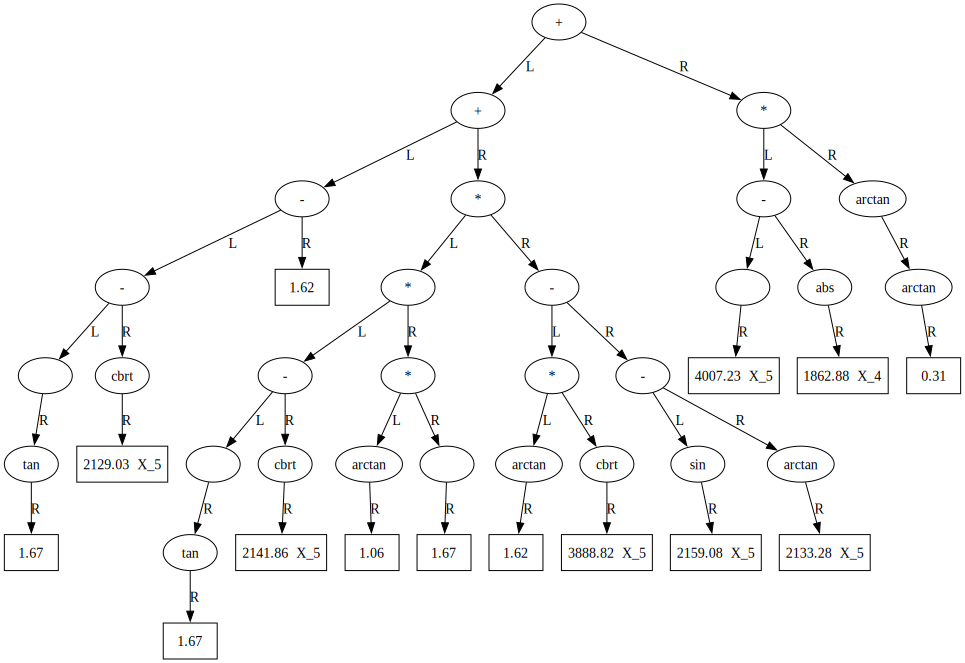

In [184]:
population = [Individual(generate_initial_solution(), 0) for i in range(POPULATION_SIZE)]
offsprings = []

# tournament -> use initial population
winners = tournament(population)

#generate population from winner/s
population = []
for w in winners:
    for i in range(int(POPULATION_SIZE/len(winners))-1):
        ind = copy.deepcopy(w)

        mutation(ind.genome)
        # recompute fitness
        ind.fitness = fitness(ind.genome) 
        population.append(ind)
    population.append(w)


population, scores = sort_individuals(population)

# ea
result = ea(population, MAX_ITERATIONS, population[0], scores[0])

# fine tuning of constants
fine_tuning(result)

print(f"Best individual mse: {mse(result.genome.root.evaluate_tree_from_node(), gb.Y)}")
print("Best individual has formula:")
result.genome.print_tree()
print("Best individual has formula:")
result.genome.draw_tree() 
